<a href="https://colab.research.google.com/github/Saiyer33/Apex-Fund/blob/main/FinancialSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#importing the necessary libraries 
import requests 
from urllib.request import urlopen
import pandas as pd
import re
import html 
from bs4 import BeautifulSoup 
!pip install htmldate
!pip install transformers
!pip install -U htmldate[all]
from htmldate import find_date
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import torch
 
  

  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
htmldate 1.2.1 requires urllib3<2,>=1.26, but you have urllib3 1.25.11 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [15]:
def run_programe(ticker,company):
    #Specifying the skeleton of the html link for all stocks on marketwatch.com with just the ticker being different for each stock
    news_url = 'https://www.marketwatch.com/investing/stock/' + ticker + '?mod=quote_search'
    links, dates = scrape_news_links(news_url)
    dates_list, positive_score, neutral_score, negative_score, Positive_sum, Neutral_sum, Negative_sum,df,links_final = scrape_news_text(links,dates)
    plot_plots(dates_list, positive_score, neutral_score, negative_score, Positive_sum, Neutral_sum, Negative_sum,df,links_final)



def scrape_news_links(news_url):
    
    #Getting the html code for the webpage pertaining to the html link 
    html = requests.get(news_url).content
    
    #Converting the html code to a beautiful soup object 
    soup = BeautifulSoup(html , 'lxml')

    #Getting a list of all links on the webpage 
    links = soup.find_all('a')
    
    #Searching for the destination of the required hyperlinks on the webpage 
    urls = []
    for link in links:
        urls.append(link.get('href'))

    #Selecting the links that are not None 
    urls1 = []
    for url in urls:
        if url is not None:
           urls1.append(url)


    #Selectng the urls that begin with "https" 
    news_urls = []
    substring = 'https://'
    for url in urls1:
        if substring in url:
           news_urls.append(url)
    
    #Selecting the urls that pertain to the stock articles of the required company 
    company_news_urls = []
    substring2 = company
    for url in news_urls:
        if substring2 in url:
           company_news_urls.append(url)

    #Removing the duplicate urls for any given article link scrapped
    links_unique = []
    for x in company_news_urls:
        if x not in links_unique:
           links_unique.append(x)

    dates = []
    
    #Getting the publishing dates of the scrapped articles 
    for link in links_unique:
        date = find_date(link)
        dates.append(date)

    return links_unique,dates

    
def scrape_news_text(links_unique,dates):

    #Initializing a list to store the news text present in the scrapped links
    news_text_list = []
    for url in links_unique:

        #Getting the html code for the webpages that have the news text 
        r = requests.get(url,headers = {'User-Agent': 'Popular browser\'s user-agent',}).content
        
        #Handling the html code for these news articles using the lxml interface to parse the content to beautiful soup
        news_soup = BeautifulSoup(r , 'lxml')
     
        #Locating the different paragraphs in the article and concatinating them into a string paragraph
        paragraphs = [par.text for par in news_soup.find_all('p')]
        news_text = '\n'.join(paragraphs)
    
        #Appending the final news text into the news text list 
        news_text_list.append(news_text)

    #Creating a pandas dataframe to store data 
    df = pd.DataFrame()

    #Creating a column to store the links for the various scrapped articles
    df['News links'] = links_unique

    #Creating a column that stores the news text of the various articles
    df['News text'] = news_text_list

    #Creating a column to store the publishing fdate of the scrapped articles 
    df['Date'] = dates

    #Basic data cleaning steps 
    for index, row in df.iterrows():
        #Removing newline characters
        row['News text'] = row['News text'].replace("\n", "")
        #Removing whitespace characters
        row['News text'] = " ".join(row['News text'].split())
        #Removing links that are not relavant to the text
        row['News text'] = re.sub(r'http\S+', '', row['News text'])

    #Tokenizing the words to help the NLP model in interpreting the meaning of the text by analyzing the sequence of the words.
    inputs = tokenizer(news_text_list, padding = True, truncation = True, return_tensors='pt')

    #Running the tokenized text through the FinBERT NLP model 
    outputs = model(**inputs)

    #Generating the sentiment score predictions for these news articles 
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    #Storing the positive, negatibve and neutral scores for each article into seperate lists
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    #Creating a dataframe that has the news text, publishing date and the respective sentiment scores on it 
    table = {'News Text':news_text_list,
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
    df = pd.DataFrame(table, columns = ["News Text", "Date", "Positive", "Negative", "Neutral"])
    df['Date'] = dates
    df['Article link'] = links_unique

    #Finding the average of the different sentiment scores for all the scrapped articles 
    Negative_score = df['Negative'].values.tolist()
    Negative_sum = sum(Negative_score)
    Negative_sum /= df.shape[0]
    Positive_score = df['Positive'].values.tolist()
    Positive_sum = sum(Positive_score)
    Positive_sum /= df.shape[0]
    Neutral_score = df['Neutral'].values.tolist()
    Neutral_sum = sum(Neutral_score)
    Neutral_sum /= df.shape[0]

    #Sorting the data in the data frame by date of publication 
    df = df.sort_values(by ='Date')

    #Converting the dates to a date-time object and storing the scores and dates in respective lists 
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    negative_score = df['Negative']
    positive_score = df['Positive']
    neutral_score = df['Neutral']
    dates_list = df['Date']
    links_final = df['Article link']
    return dates_list, positive_score, neutral_score, negative_score, Positive_sum, Neutral_sum, Negative_sum,df,links_final

def plot_plots(dates_list, positive_score, neutral_score, negative_score, Positive_sum, Neutral_sum, Negative_sum,df,links_final):

    #Creating a plot using matplotlib
    plt.figure(figsize = (20,6))

    #getting the number of x axis values that need to be plotted and specifying the width of the bars in the plot
    N = len(dates_list)
    ind = np.arange(N) 
    width = 0.25
  
    #Representing the positive scores in a green bar 
    xvals = positive_score
    bar1 = plt.bar(ind, xvals, width, color = 'g')

    #Representing the neutral scores in a blue bar 
    zvals = neutral_score
    bar3 = plt.bar(ind+width, zvals, width, color = 'b')

    #Representing the negative scores in a red bar 
    yvals = negative_score
    bar2 = plt.bar(ind+width*2, yvals, width, color='r')
  
    #Labelling the axis and the title of the plot
    plt.xlabel("Dates")
    plt.ylabel('Scores')
    plt.title("Sentiment Scores")

    #Making certain orientation adjustments and creating a legend for the plot
    plt.xticks(ind+width,dates_list)
    plt.xticks(rotation=60)
    plt.legend((bar1, bar3, bar2), ('Positive Score', 'Neutral Score', 'Negative Score'))
    plt.show()
    
    #Printing a newline
    print()

    #Printing the dates and links in the dataframe
    for i in range (0,len(dates_list)):
         print(dates_list[i].strftime('%Y-%m-%d') + ' , ' + links_final[i] + "\n")

    #Printing a newline
    print()

    plt.figure(2, figsize = (20,6))
      #getting the number of x axis values that need to be plotted and specifying the width of the bars in the plot
    M = 1
    ind = np.arange(M) 
    width = 0.7
  
    #Representing the positive scores in a green bar 
    xvals = Positive_sum
    bar1 = plt.bar(ind, xvals, width, color = 'g')

    #Representing the neutral scores in a blue bar 
    zvals = Neutral_sum
    bar3 = plt.bar(ind+width, zvals, width, color = 'b')

    #Representing the negative scores in a red bar 
    yvals = Negative_sum
    bar2 = plt.bar(ind+width*2, yvals, width, color='r')
  
    #Labelling the axis and the title of the plot
    plt.xlabel("Date range from " + str(dates_list[0]) + " to " + str(dates_list[N-1]))
    plt.ylabel('Scores')
    plt.title("Average Sentiment Scores for range " + str(dates_list[0]) + "to" + str(dates_list[N-1]))

    #Making certain orientation adjustments and creating a legend for the plot
    plt.xticks([])
    plt.legend((bar1, bar3, bar2), ('Positive Score', 'Neutral Score', 'Negative Score'))
    plt.show()



Enter the stock ticker in lowercase: tsla
Enter the company name in lowercase: tesla


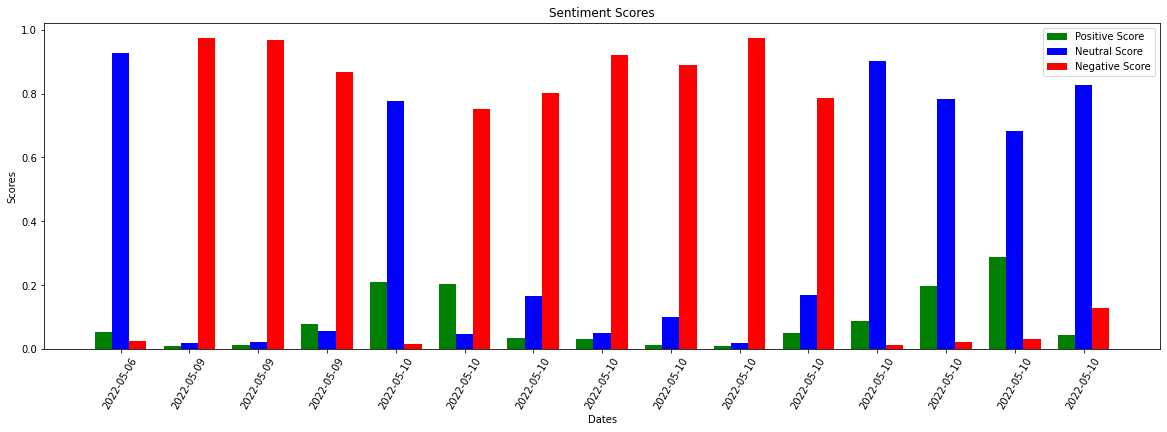


2022-05-10 , https://www.marketwatch.com/articles/tesla-will-expand-shanghai-factory-51652217552?mod=mw_quote_news

2022-05-10 , https://www.marketwatch.com/story/tesla-inc-stock-rises-tuesday-outperforms-market-01652214775-bb316510ab29?mod=mw_quote_news

2022-05-10 , https://www.marketwatch.com/articles/rivian-lordstown-tesla-cash-ev-makers-51652202279?mod=mw_quote_news

2022-05-10 , https://www.marketwatch.com/articles/gm-ford-tesla-stock-rating-auto-makers-51652194854?mod=mw_quote_news

2022-05-10 , https://www.marketwatch.com/story/cathie-wood-wades-into-gm-as-she-trims-tesla-stake-further-11652190404?mod=mw_quote_news

2022-05-10 , https://www.marketwatch.com/articles/tesla-shanghai-factory-parts-shortage-covid-51652185209?mod=mw_quote_news

2022-05-10 , https://www.marketwatch.com/articles/nvidia-tesla-beaten-up-stocks-improving-earnings-outlooks-51652137314?mod=mw_quote_news

2022-05-09 , https://www.marketwatch.com/story/tesla-suspends-production-at-shanghai-plant-due-to-suppl

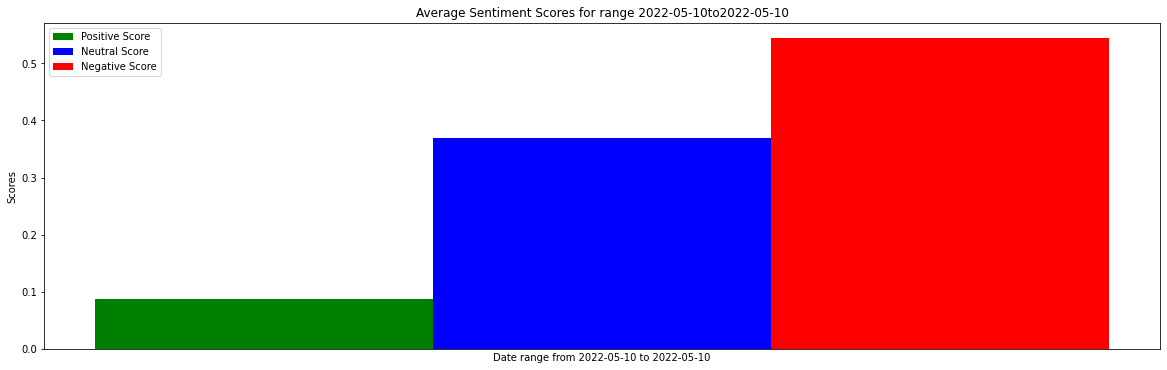

In [16]:
#Asking the user to input the ticker and company name in lowercase for processing 
ticker = input("Enter the stock ticker in lowercase: ")
company = input("Enter the company name in lowercase: ")

#Calling the fuction that generates the final plot 
run_programe(ticker,company)